# Загрузка данных

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('day.csv')

In [3]:
data = data.drop(columns=["instant"])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      731 non-null    object 
 1   season      731 non-null    int64  
 2   yr          731 non-null    int64  
 3   mnth        731 non-null    int64  
 4   holiday     731 non-null    int64  
 5   weekday     731 non-null    int64  
 6   workingday  731 non-null    int64  
 7   weathersit  731 non-null    int64  
 8   temp        731 non-null    float64
 9   atemp       731 non-null    float64
 10  hum         731 non-null    float64
 11  windspeed   731 non-null    float64
 12  casual      731 non-null    int64  
 13  registered  731 non-null    int64  
 14  cnt         731 non-null    int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 85.8+ KB


In [5]:
data

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


# Задание

## Все функции + реализация Доп задания с лагами

In [15]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

# Функция для построения модели с добавлением константы
def build_model(X, y):
    X_const = X.assign(const=1.0)
    model = sm.OLS(y, X_const).fit()
    #print(model.summary())
    return model

# Функция для предсказания (без добавления константы)
def predict_model(model, X):
    X = X.assign(const=1.0)
    y_pred = model.predict(X)
    return y_pred

# Функция для оценки модели
def evaluate_model(X, y, model, y_pred):
    r_squared = model.rsquared if hasattr(model, 'rsquared') else model.score(X, y)
    print(f"Коэффициент детерминации (R²): {r_squared}")
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    print(f"RMSE: {rmse}")
    error_e = np.mean(np.abs((y - y_pred) / y_pred))
    print(f"Ошибка E: {error_e}")
    return r_squared, rmse, error_e

# Функция для выбора значимых факторов
def exclude_factors(model, X, y, p_value_threshold, correlation_threshold, corr_with_target_threshold):
    # Получаем p-values из модели
    p_values = model.pvalues
    # Исключаем факторы с p-value выше порога
    significant_factors = p_values[p_values < p_value_threshold].index.tolist()
    if 'const' in significant_factors:
        significant_factors.remove('const')  # Убираем константу

    # Считаем корреляцию факторов между собой
    corr_matrix = X.corr()

    # Исключаем факторы с высокой корреляцией между собой (по выбору пользователя)
    to_exclude = []
    for factor in significant_factors:
        for other in significant_factors:
            if factor != other and abs(corr_matrix.loc[factor, other]) > correlation_threshold:
                to_exclude.append(factor)
                break  # Исключаем только один из пары сильно коррелирующих факторов

    # Также учитываем корреляцию с откликом (target)
    corr_with_target = X.corrwith(y)
    for factor in significant_factors:
        if abs(corr_with_target[factor]) < corr_with_target_threshold:
            to_exclude.append(factor)

    # Формируем новый набор факторов
    final_factors = [f for f in significant_factors if f not in to_exclude]
    X_reduced = X[final_factors]

    print(f"Исключены факторы: {set(X.columns) - set(final_factors)}")

    return X_reduced

# Функция для добавления лагов
def add_time_lags(df, columns, max_lag):
    for col in columns:
        for lag in range(1, max_lag + 1):
            df[f"{col}_lag{lag}"] = df[col].shift(lag)
    return df

# Функция для гипертюнинга лагов
def tune_lags(data, factors, response_col, max_lag):
    best_lag = None
    best_error = float('inf')
    for lag in range(1, max_lag + 1):
        lagged_data = add_time_lags(data.copy(), factors, lag).dropna()
        X = lagged_data.drop(columns=[response_col, 'dteday', 'casual', 'registered'])
        y = lagged_data[response_col]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = build_model(X_train, y_train)
        y_pred = predict_model(model, X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        if rmse < best_error:
            best_error = rmse
            best_lag = lag

    print(f"Оптимальный лаг: {best_lag}, RMSE: {best_error}")
    return best_lag

# Регуляризация с Ridge-регрессией
def ridge_regularization(X_train, y_train, X_test, y_test):
    ridge = Ridge()
    params = {'alpha': np.logspace(-4, 4, 50)}
    grid = GridSearchCV(ridge, params, scoring='neg_mean_squared_error', cv=5)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Лучший параметр alpha: {grid.best_params_['alpha']}")
    print(f"RMSE на тестовой выборке: {rmse}")
    return best_model

# Кросс-валидация
def cross_validate_model(X, y, cv=5):
    X_const = X.assign(const=1.0)
    model = sm.OLS(y, X_const).fit()
    scores = cross_val_score(
        Ridge(alpha=1.0), X_const, y, scoring='neg_mean_squared_error', cv=cv
    )
    mean_rmse = np.sqrt(-np.mean(scores))
    print(f"Среднее RMSE на кросс-валидации: {mean_rmse}")
    return mean_rmse

# Основной блок кода
p_value_threshold = float(input("Введите порог для p-value (например, 0.05): "))
correlation_threshold = float(input("Введите порог для корреляции между факторами (например, 0.7): "))
corr_with_target_threshold = float(input("Введите порог для корреляции с откликом (например, 0.3): "))

max_lag = 10
factors = ['temp', 'hum', 'windspeed']
optimal_lag = tune_lags(data, factors, 'cnt', max_lag)

data_with_lags = add_time_lags(data.copy(), factors, optimal_lag).dropna()

X = data_with_lags.drop(columns=['cnt', 'dteday', 'casual', 'registered'])
y = data_with_lags['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Регуляризация
best_ridge_model = ridge_regularization(X_train, y_train, X_test, y_test)

# Кросс-валидация
cross_validate_model(X, y)

# Обучение базовой модели
model_base = build_model(X_train, y_train)

# Предсказания на тестовых данных
y_pred_test_full = predict_model(model_base, X_test)

# Оценка базовой модели
evaluate_model(X_test, y_test, model_base, y_pred_test_full)

print(model_base.summary())


Введите порог для p-value (например, 0.05): 0.05
Введите порог для корреляции между факторами (например, 0.7): 0.7
Введите порог для корреляции с откликом (например, 0.3): 0.3
Оптимальный лаг: 2, RMSE: 756.681948403821
Лучший параметр alpha: 0.5689866029018293
RMSE на тестовой выборке: 763.853610050643
Среднее RMSE на кросс-валидации: 1006.5399378460473
Коэффициент детерминации (R²): 0.7954877075479299
RMSE: 756.681948403821
Ошибка E: 0.18929990876377475
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     129.3
Date:                Tue, 10 Dec 2024   Prob (F-statistic):          6.61e-182
Time:                        15:49:31   Log-Likelihood:                -4776.7
No. Observations:                 583   AIC:                       

## Линейная регрессия без файнтюнинга лагов

In [16]:
# Разделяем данные
X = data.drop(columns=['cnt', 'dteday', 'casual', 'registered'])
y = data['cnt']

train_size = int(0.8 * len(X))

# Разделяем данные
X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

# Обучение модели с полным набором факторов
model_base = build_model(X_train, y_train)
print(model_base.summary())

# Предсказания на тестовых данных с полными факторами
y_pred_test_full = predict_model(model_base, X_test)

# Оценка модели на тестовых данных с полными факторами
evaluate_model(X_test, y_test, model_base, y_pred_test_full)

# Применяем функцию exclude_factors для выбора значимых факторов
X_train_reduced = exclude_factors(model_base, X_train, y_train, p_value_threshold, correlation_threshold, corr_with_target_threshold)
X_test_reduced = X_test[X_train_reduced.columns]

# Строим модель с отобранными значениями факторов
model_reduced = build_model(X_train_reduced, y_train)
print(model_reduced.summary())

# Предсказания на тестовых данных с уменьшенными факторами
y_pred_test_reduced = predict_model(model_reduced, X_test_reduced)

# Оценка модели на тестовых данных с уменьшенными факторами
evaluate_model(X_test_reduced, y_test, model_reduced, y_pred_test_reduced)



                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     207.7
Date:                Tue, 10 Dec 2024   Prob (F-statistic):          1.42e-191
Time:                        15:50:21   Log-Likelihood:                -4732.3
No. Observations:                 584   AIC:                             9489.
Df Residuals:                     572   BIC:                             9541.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season       296.7419     66.429      4.467      0.0

(0.7514237872508918, 1470.7303861995697, 0.2606423867161126)

## Графики сравнения лог регрессий

<ipython-input-17-5667e3fff3b7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['year'] = X_test['yr'].map({0: 2011, 1: 2012})
<ipython-input-17-5667e3fff3b7>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['y_test'] = y_test
<ipython-input-17-5667e3fff3b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

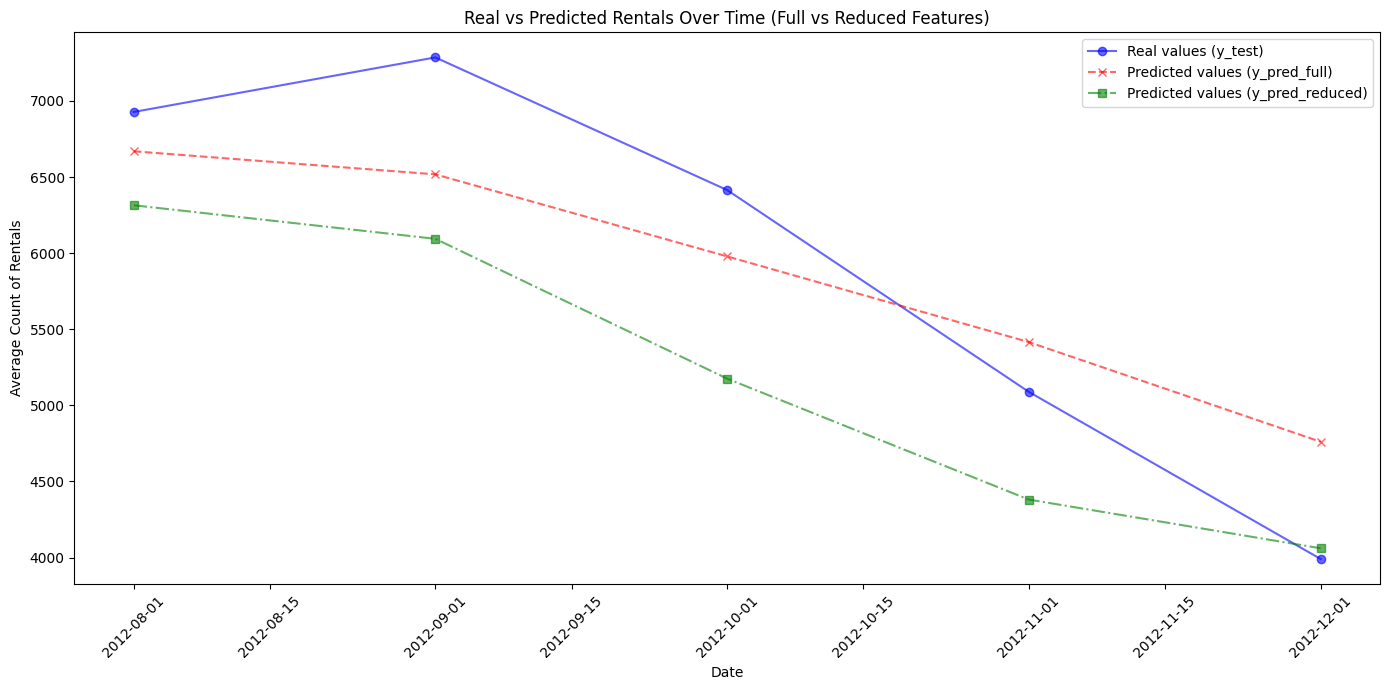

In [17]:
# Функция для построения графика реальных и предсказанных значений с двумя моделями
def plot_real_vs_predicted(X_test, y_test, y_pred_test, y_pred_test_reduced):
    """
    Функция для построения графика реальных и предсказанных значений с двумя моделями.

    Parameters:
    X_test (pd.DataFrame): Данные теста с признаками, включая 'yr' и 'mnth'.
    y_test (pd.Series): Реальные значения для теста.
    y_pred_test (pd.Series): Предсказанные значения для теста (полная модель).
    y_pred_test_reduced (pd.Series): Предсказанные значения для теста (уменьшенная модель).
    """
    # Преобразуем значения yr в реальные годы
    X_test['year'] = X_test['yr'].map({0: 2011, 1: 2012})

    # Добавляем столбцы с реальными значениями и предсказаниями в X_test
    X_test['y_test'] = y_test
    X_test['y_pred_test'] = y_pred_test
    X_test['y_pred_test_reduced'] = y_pred_test_reduced

    # Группируем данные по году и месяцу, вычисляем средние значения
    monthly_data = X_test.groupby(['year', 'mnth']).agg({'y_test': 'mean', 'y_pred_test': 'mean', 'y_pred_test_reduced': 'mean'}).reset_index()

    # Создаем новый столбец 'date' для отображения даты в формате год-месяц
    monthly_data['date'] = pd.to_datetime(monthly_data['year'].astype(str) + '-' + monthly_data['mnth'].astype(str).str.zfill(2))

    # Построение графика
    plt.figure(figsize=(14, 7))

    # График реальных значений
    plt.plot(monthly_data['date'], monthly_data['y_test'], label='Real values (y_test)', color='blue', marker='o', linestyle='-', alpha=0.6)

    # График предсказанных значений с полными факторами
    plt.plot(monthly_data['date'], monthly_data['y_pred_test'], label='Predicted values (y_pred_full)', color='red', marker='x', linestyle='--', alpha=0.6)

    # График предсказанных значений с уменьшенными факторами
    plt.plot(monthly_data['date'], monthly_data['y_pred_test_reduced'], label='Predicted values (y_pred_reduced)', color='green', marker='s', linestyle='-.', alpha=0.6)

    # Настройки графика
    plt.xlabel('Date')
    plt.ylabel('Average Count of Rentals')
    plt.title('Real vs Predicted Rentals Over Time (Full vs Reduced Features)')
    plt.xticks(rotation=45)  # Поворот меток по оси X для улучшения читаемости
    plt.legend()

    # Отображаем график
    plt.tight_layout()
    plt.show()

# Построение графика
plot_real_vs_predicted(X_test, y_test, y_pred_test_full, y_pred_test_reduced)

## Оценка адекватности построенных моделей

In [18]:
from scipy.stats import f

# Оценка адекватности модели
def evaluate_model_adéquacy(X, y, y_pred, model):
    """
    Оценка адекватности модели: R², F-статистика, ошибка (E) и RMSE.

    Parameters:
    X (pd.DataFrame): Данные для модели.
    y (pd.Series): Реальные значения для модели.
    y_pred (pd.Series): Предсказанные значения.
    """
    n = len(y)

    # 1. Коэффициент детерминации (R²)
    # Оценка R²
    r_squared = model.rsquared if hasattr(model, 'rsquared') else model.score(X, y)

    # 2. F-статистика (анализ с использованием OLS из statsmodels)
    f_statistic = model.fvalue  # F-статистика из результатов модели

    # 3. Ошибка (E)
    error = np.mean(np.abs((y - y_pred) / y))

    # 4. RMSE
    rmse = np.sqrt(mean_squared_error(y, y_pred))  # Вычисляем RMSE

    # Выводим результаты
    print(f"Коэффициент детерминации (R²): {r_squared:.4f}")
    print(f"F-статистика: {f_statistic:.4f}")
    print(f"Ошибка (E): {error:.4f}")
    print(f"RMSE: {rmse:.4f}")

    # Проверка адекватности модели

    # Степени свободы для числителя и знаменателя
    dfn = X.shape[1]  # Количество факторов в модели
    dfd = len(y) - X.shape[1] - 1  # Степени свободы для остаточного

    # Уровень значимости 0.05
    alpha = 0.05

    # Критическое значение F для уровня значимости 0.05
    f_critical = f.ppf(1 - 0.05, dfn, dfd)

    # Проверка адекватности модели
    if f_statistic > f_critical:
        print("Модель адекватна.")
    else:
        print("Модель неадекватна.")

# Оценка модели на тестовых данных с полными факторами
evaluate_model_adéquacy(X_test, y_test, y_pred_test_full, model_base)

# Оценка модели на тестовых данных с уменьшенными факторами
evaluate_model_adéquacy(X_test_reduced, y_test, y_pred_test_reduced, model_reduced)

Коэффициент детерминации (R²): 0.7998
F-статистика: 207.7105
Ошибка (E): 1.5999
RMSE: 1166.0203
Модель адекватна.
Коэффициент детерминации (R²): 0.7514
F-статистика: 584.4295
Ошибка (E): 1.5367
RMSE: 1470.7304
Модель адекватна.
